In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from scipy.stats import wasserstein_distance
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')


In [175]:
import numpy as np
import pandas as pd

sgrna_key_tbl = (
    pd.read_csv("metadata/MG-L-0045_full_library.csv")

    .assign(
        barcode=lambda df: df['barcode'].str.extract(r'([ACGT]{10})')[0],
        sgrna=lambda df: (
            df['sgrna']
              .str.replace('ALT-Full-', '', regex=False)
              .str.upper()
        )
    )

    .assign(
        gene_symbol=lambda df: (
            df['sgrna']
              .str.replace(r'-\d{1,2}$', '', regex=True)
              .str.replace(r'^(SAFE-T[1-4])-.+$', r'\1', regex=True)
              .str.lower()
        )
    )
    # now bin into classes
    .assign(
        class_=lambda df: np.where(
            df['gene_symbol']=='ntc', 'Scramble',
        np.where(
            df['gene_symbol'].str.startswith('safe'), 'Safe',
            'Library'
        ))
    )
)

print(sgrna_key_tbl[['sgrna','gene_symbol','class_']].drop_duplicates())



         sgrna gene_symbol    class_
0     MARCH8-1      march8   Library
1     MARCH8-2      march8   Library
2     MARCH8-3      march8   Library
3     MARCH8-4      march8   Library
4     MARCH8-5      march8   Library
...        ...         ...       ...
5299    NTC-46         ntc  Scramble
5300    NTC-47         ntc  Scramble
5301    NTC-48         ntc  Scramble
5302    NTC-49         ntc  Scramble
5303    NTC-50         ntc  Scramble

[5304 rows x 3 columns]


In [176]:
# Read cell data
csv_files = glob.glob("metadata/micronuclei/**/*.csv", recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read all CSV files and combine them
cell_data_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df['file'] = file
    cell_data_list.append(df)

cell_tbl = pd.concat(cell_data_list, ignore_index=True)

print(cell_tbl.info())
print(cell_tbl.head())


Found 1 CSV files
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105951 entries, 0 to 1105950
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1105951 non-null  int64  
 1   cell_barcode_0        1105951 non-null  object 
 2   cell_barcode_count_0  1105951 non-null  float64
 3   cell_barcode_1        693669 non-null   object 
 4   cell_barcode_count_1  1105951 non-null  float64
 5   Micronuclei_Count     1105360 non-null  float64
 6   shortened_x           916785 non-null   object 
 7   Gene_0                916785 non-null   object 
 8   shortened_y           427873 non-null   object 
 9   Gene_1                427873 non-null   object 
 10  gene_used             1105951 non-null  object 
 11  sgRNA_used            1105951 non-null  object 
 12  file                  1105951 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 109.7+ MB
None
   Un

In [177]:
cell_tbl

,Unnamed: 0,cell_barcode_0,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,Micronuclei_Count,shortened_x,Gene_0,shortened_y,Gene_1,gene_used,sgRNA_used,file
0,106,GTGGCAAGGA,1.0,NaN,0.0,0.0,GTGGCAAGGA,TMX2,NaN,NaN,TMX2,GTGGCAAGGA,metadata/micronuclei/1000geneScreenExportJuly1...
1,114,GTGGCAAGGA,1.0,NaN,0.0,0.0,GTGGCAAGGA,TMX2,NaN,NaN,TMX2,GTGGCAAGGA,metadata/micronuclei/1000geneScreenExportJuly1...
2,124,TTGTCATAGA,1.0,NaN,0.0,0.0,TTGTCATAGA,ASNS,NaN,NaN,ASNS,TTGTCATAGA,metadata/micronuclei/1000geneScreenExportJuly1...
3,125,AGACTGGACA,1.0,NaN,0.0,0.0,AGACTGGACA,TSEN34,NaN,NaN,TSEN34,AGACTGGACA,metadata/micronuclei/1000geneScreenExportJuly1...
4,131,CTCAATCAGG,1.0,NaN,0.0,0.0,CTCAATCAGG,MCM3AP,NaN,NaN,MCM3AP,CTCAATCAGG,metadata/micronuclei/1000geneScreenExportJuly1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105946,3791425,GCTACCGTAC,1.0,NaN,0.0,0.0,GCTACCGTAC,TOPORS,NaN,NaN,TOPORS,GCTACCGTAC,metadata/micronuclei/1000geneScreenExportJuly1...
1105947,3791426,ATTGTGGGTT,1.0,CCCTGGAACT,1.0,0.0,ATTGTGGGTT,NTRK1,CCCTGGAACT,TIMM17A,NTRK1,ATTGTGGGTT,metadata/micronuclei/1000geneScreenExportJuly1...
1105948,3791427,GCAAATAAAA,1.0,GCAACTAAAC,1.0,0.0,NaN,NaN,GCAACTAAAC,NSMCE2,NSMCE2,GCAACTAAAC,metadata/micronuclei/1000geneScreenExportJuly1...
1105949,3791432,CCTCTCGGCG,1.0,GCGGCTCTTA,1.0,0.0,NaN,NaN,GCGGCTCTTA,ACTR3C,ACTR3C,GCGGCTCTTA,metadata/micronuclei/1000geneScreenExportJuly1...


## Fishers test

In [178]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.proportion import proportions_ztest


number_of_cells_threshold = 100
n_reps = 10000

df = cell_tbl.assign(has_mni=lambda d: d['Micronuclei_Count'] > 0)


ctrl_summary = (
    df[df['gene_used'] == 'NTC']
    .groupby('sgRNA_used')
    .agg(
        n_cells=('has_mni', 'size'),
        n_mni  =('Micronuclei_Count', 'sum')
    )
    .reset_index()
)
ctrl_summary = ctrl_summary[ctrl_summary['n_cells'] >= number_of_cells_threshold].copy()


sgrna_summary = (
    df
    .groupby('sgRNA_used')
    .agg(
        n_cells=('has_mni', 'size'),
        n_mni  =('Micronuclei_Count', 'sum')
    )
    .reset_index()
)

sgrna_summary = sgrna_summary[sgrna_summary['n_cells'] >= number_of_cells_threshold].copy()



def compute_odds_ratio(row):
    a = row['n_mni']
    b = row['n_cells'] - row['n_mni']
    c = ctrl_summary['n_mni'].sum()
    d = ctrl_summary['n_cells'].sum() - c
    odds, _ = fisher_exact([[a, b], [c, d]], alternative='greater')
    return odds
    
total_mni   = ctrl_summary['n_mni'].sum()
total_cells = ctrl_summary['n_cells'].sum()

def compute_zprop(row):

    a = row['n_mni']          
    b = row['n_cells'] - a    
    # pooled NTC successes / failures
    c = total_mni
    d = total_cells - c

    counts = np.array([a, c])
    nobs   = np.array([a + b, c + d])
    z, _ = proportions_ztest(counts, nobs, alternative='larger')
    return z

sgrna_summary['odds_ratio'] = sgrna_summary.apply(compute_odds_ratio, axis=1)




sg_tbl = (
    sgrna_summary
    .merge(
        sgrna_key_tbl[['barcode', 'sgrna']],
        how='left',
        left_on='sgRNA_used',
        right_on='barcode'
    )
    .drop(columns=['barcode'])
    .rename(columns={'sgrna': 'sgrna_name'})
)



In [158]:
sg_tbl

,sgRNA_used,n_cells,n_mni,odds_ratio,sgrna_name
0,AAAAAGAGAG,134,11.0,1.810167,FKBP5-5
1,AAAACCCCTG,226,14.0,1.336667,ZBTB9-5
2,AAAACTGCAC,151,8.0,1.132362,PHF6-5
3,AAAAGACAAC,138,6.0,0.920044,SLC35E1-5
4,AAAAGCGCAT,288,19.0,1.429659,RADX-5
...,...,...,...,...,...
4022,TTTGTCTCAC,149,14.0,2.099063,MMS22L-4
4023,TTTTCATTAT,143,6.0,0.886466,GMNN-6
4024,TTTTGCGGGG,316,21.0,1.440882,HEMGN-2
4025,TTTTGTATGC,172,12.0,1.518072,ST13-2


In [159]:
sgrna_summary

,sgRNA_used,n_cells,n_mni,odds_ratio
0,AAAAAGAGAG,134,11.0,1.810167
2,AAAACCCCTG,226,14.0,1.336667
4,AAAACTGCAC,151,8.0,1.132362
6,AAAAGACAAC,138,6.0,0.920044
7,AAAAGCGCAT,288,19.0,1.429659
...,...,...,...,...
5277,TTTGTCTCAC,149,14.0,2.099063
5279,TTTTCATTAT,143,6.0,0.886466
5280,TTTTGCGGGG,316,21.0,1.440882
5281,TTTTGTATGC,172,12.0,1.518072


In [179]:
import numpy as np

n_reps = 10000


#Identify NTC guides in sg_tbl
null_guides = sg_tbl[
    sg_tbl['sgrna_name'].str.contains('NTC', case=False, na=False)
].copy()

n_null = len(null_guides)
if n_null < 6:
    raise ValueError(f"Need ≥6 NTC sgRNAs in sg_tbl; found {n_null}")

# Build empirical null of 2nd‐highest odds_ratio
null_odds = np.empty(n_reps)
np.random.seed(42)

for i in range(n_reps):
    # sample 6 null odds_ratio values
    sampled = null_guides['odds_ratio'].sample(n=6, replace=True)
    # pick the second highest
    top2 = sampled.nlargest(2).values
    null_odds[i] = top2[1] if len(top2) >= 2 else top2[0]

# --------------------------
# 3) Summarize
mean_null   = null_odds.mean()
std_null    = null_odds.std(ddof=0)
p5_null     = np.percentile(null_odds, 5)
p50_null    = np.percentile(null_odds, 50)
p95_null    = np.percentile(null_odds, 95)

print("NTC odds_ratio null distribution (2nd-highest of 6):")
print(f"  Mean: {mean_null:.4f}")
print(f"   Std: {std_null:.4f}")
print(f"   5% : {p5_null:.4f}")
print(f"  50% : {p50_null:.4f}")
print(f"  95% : {p95_null:.4f}")


NTC odds_ratio null distribution (2nd-highest of 6):
  Mean: 1.2223
   Std: 0.2247
   5% : 0.8956
  50% : 1.1829
  95% : 1.6867


In [180]:
from statsmodels.stats.multitest import multipletests

# Compute empirical p-values from null_odds
if len(null_odds) > 1:
    p_values = [
        (null_odds >= or_val).mean()
        for or_val in sg_tbl['odds_ratio']
    ]
    sg_tbl['empirical_p'] = p_values

    # 2) FDR Benjamini–Hochberg correction
    _, p_corrected, _, _ = multipletests(sg_tbl['empirical_p'], method='fdr_bh')
    sg_tbl['empirical_p_corrected'] = p_corrected
else:
    raise ValueError("null_odds must contain at least 2 values to compute p-values")


In [181]:

sg_tbl_1 = (
    sg_tbl
    .merge(
        sgrna_key_tbl[['barcode', 'gene_symbol']],
        how='left',
        left_on='sgRNA_used',
        right_on='barcode'
    )
    .drop(columns=['barcode'])
    
)
print(sg_tbl_1)

sg_tbl_1_second = (
    sg_tbl_1
    .sort_values(['gene_symbol', 'odds_ratio'], ascending=[True, False])
    .groupby('gene_symbol')
    .nth(1)            # 0 = highest, 1 = second‑highest
    .reset_index()
)


      sgRNA_used  n_cells  n_mni  odds_ratio sgrna_name  empirical_p  \
0     AAAAAGAGAG      134   11.0    1.810167    FKBP5-5       0.0092   
1     AAAACCCCTG      226   14.0    1.336667    ZBTB9-5       0.2736   
2     AAAACTGCAC      151    8.0    1.132362     PHF6-5       0.6178   
3     AAAAGACAAC      138    6.0    0.920044  SLC35E1-5       0.9272   
4     AAAAGCGCAT      288   19.0    1.429659     RADX-5       0.1620   
...          ...      ...    ...         ...        ...          ...   
4058  TTTGTCTCAC      149   14.0    2.099063   MMS22L-4       0.0000   
4059  TTTTCATTAT      143    6.0    0.886466     GMNN-6       0.9877   
4060  TTTTGCGGGG      316   21.0    1.440882    HEMGN-2       0.1620   
4061  TTTTGTATGC      172   12.0    1.518072     ST13-2       0.1136   
4062  TTTTGTGGCT      226   12.0    1.135007   ZNF644-4       0.6178   

      empirical_p_corrected gene_symbol  
0                  0.087585       fkbp5  
1                  0.724383       zbtb9  
2        

In [182]:
import numpy as np
import pandas as pd


# List of safe genes
safe_genes = [f"safe-t{i}" for i in range(1, 5)]

# Parameters
n_reps = 10000
sample_size = 6
rng = np.random.default_rng(42)

results = []
for gene in safe_genes:
    subset = sg_tbl_1[sg_tbl_1['gene_symbol'].str.lower() == gene]
    odds = subset['odds_ratio'].values
    if len(odds) < sample_size:
        mean_second = np.nan
    else:

        second_highs = []
        for _ in range(n_reps):
            sample = rng.choice(odds, size=sample_size, replace=True)
            second_highs.append(np.sort(sample)[-2])
        mean_second = np.mean(second_highs)
    results.append({
        'gene_symbol': gene,
        'n_guides': len(odds),
        'expected_second_odds_ratio': mean_second
    })

# Create DataFrame and display
res_df = pd.DataFrame(results)


In [183]:
# List of safe genes
safe_genes = [f"safe-t{i}" for i in range(1,5)]

lookup = dict(zip(res_df['gene_symbol'], res_df['expected_second_odds_ratio']))

mask = sg_tbl_1_second['gene_symbol'].isin(safe_genes)
sg_tbl_1_second.loc[mask, 'odds_ratio'] = sg_tbl_1_second.loc[mask, 'gene_symbol'].map(lookup)


In [184]:
sg_tbl_1_second.info

<bound method DataFrame.info of     gene_symbol  sgRNA_used  n_cells  n_mni  odds_ratio sgrna_name  \
0       abhd14b  GAGGGCACCA      336   22.0    1.418157  ABHD14B-4   
1         acot8  ATTACTGGGT      320   21.0    1.421606    ACOT8-5   
2         actc1  TGCCAAGATG      176   10.0    1.219335    ACTC1-1   
3         actn2  GAATGGCCTG      434   33.0    1.665715    ACTN2-4   
4        actr3c  TGTGCGGCGT      149   11.0    1.613410   ACTR3C-1   
..          ...         ...      ...    ...         ...        ...   
832      znf773  GTGACTTCAG      206    9.0    0.924714   ZNF773-5   
833      znf827  CCGTCAGGTT      264   22.0    1.840088   ZNF827-2   
834      znf829  TCAGGCCGCT      366   22.0    1.294480   ZNF829-3   
835      zranb1  ACGGCCGGAT      342   17.0    1.058758   ZRANB1-1   
836     zscan22  GTCAAGGCAT      119    8.0    1.458808  ZSCAN22-3   

     empirical_p  empirical_p_corrected  
0         0.1620               0.575286  
1         0.1620               0.575286  
2

In [185]:
sg_tbl_1_second[sg_tbl_1_second['gene_symbol'] == 'safe-t4']

,gene_symbol,sgRNA_used,n_cells,n_mni,odds_ratio,sgrna_name,empirical_p,empirical_p_corrected
607,safe-t4,TGCCTGATGA,169,19.0,1.727993,SAFE-T4-22,0.0,0.0


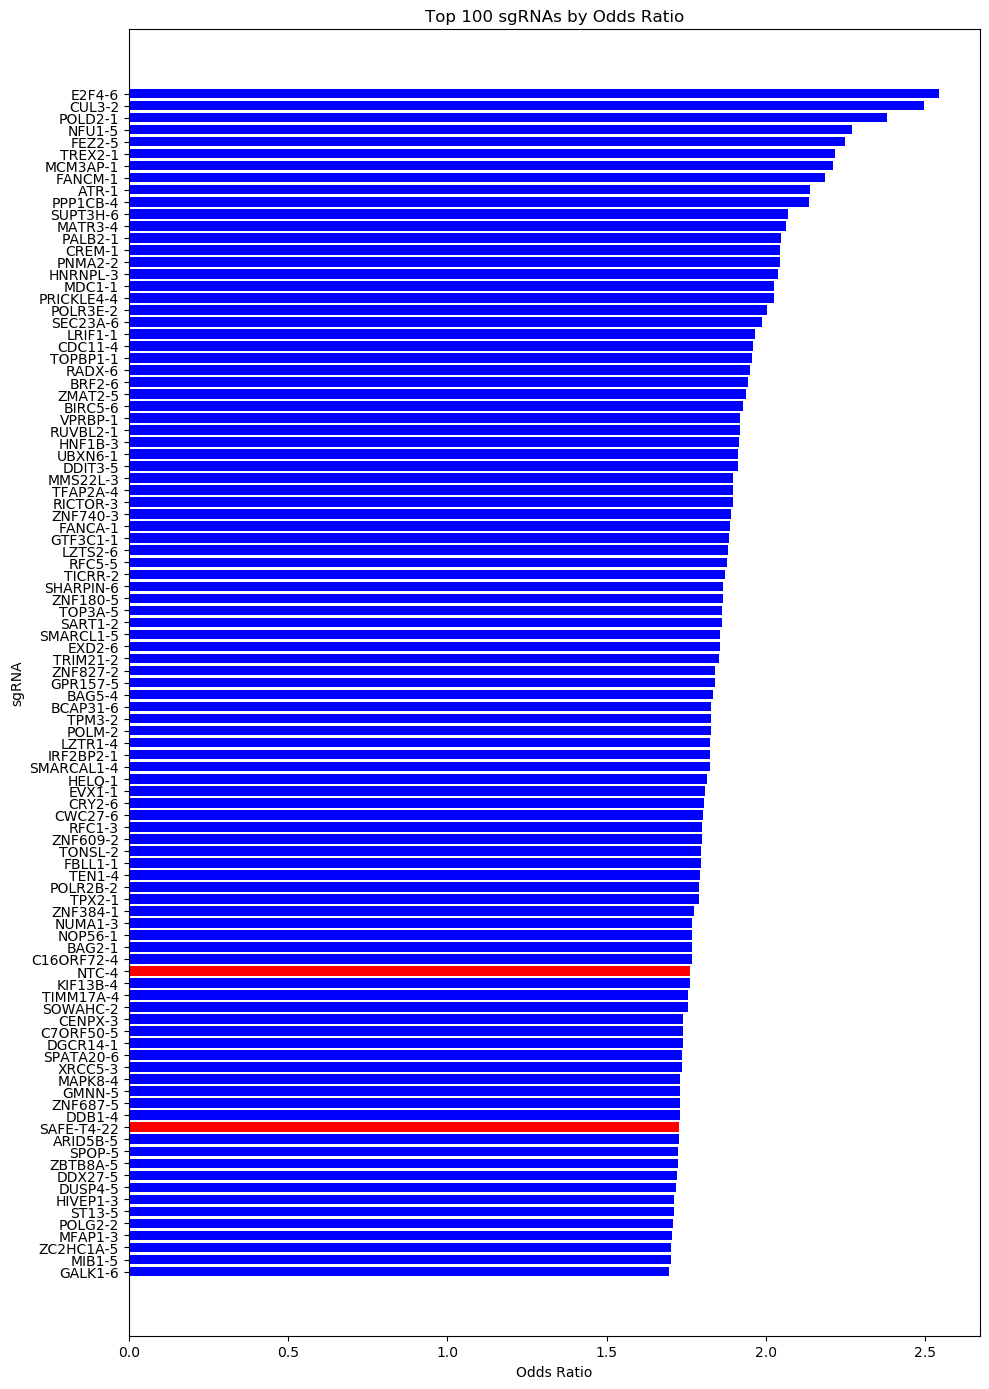

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Plot top sgRNAs by odds_ratio

top_n = 100

# 1) Select top guides by odds_ratio
df_top = (
    sg_tbl_1_second
    .sort_values('odds_ratio', ascending=False)
    .head(top_n)
    .copy()
)

# 2) Use odds_ratio directly as plot_score
df_top['plot_score'] = df_top['odds_ratio']

# 3) Flag NTC or safe genes in red
is_control = df_top['gene_symbol'].str.contains(r'NTC|safe', case=False, na=False)
df_top['color'] = np.where(is_control, 'red', 'blue')

# 4) Plot horizontal bar chart
plt.figure(figsize=(10, 14))
plt.barh(
    df_top['sgrna_name'][::-1],
    df_top['plot_score'][::-1],
    color=df_top['color'][::-1]
)

plt.xlabel('Odds Ratio')
plt.ylabel('sgRNA')
plt.title(f'Top {top_n} sgRNAs by Odds Ratio')
plt.tight_layout()
plt.show()


In [54]:
df_top

,sgRNA_used,n_cells,n_mni,odds_ratio,sgrna_name,empirical_p,empirical_p_corrected,plot_score,color
3523,TCAGAAGACA,140,26.0,4.616360,RFC2-4,0.0,0.0,4.616360,blue
3741,TGATCGTATT,110,20.0,4.497992,RFC1-1,0.0,0.0,4.497992,blue
1719,CGACTCTACT,113,17.0,3.584337,PRICKLE4-6,0.0,0.0,3.584337,blue
287,ACAGTTGCAT,113,17.0,3.584337,POLR2B-3,0.0,0.0,3.584337,blue
3469,TATACTAGAG,100,14.0,3.295041,SAFE-T4-35,0.0,0.0,3.295041,blue
...,...,...,...,...,...,...,...,...,...
419,ACGTTGAGGT,262,26.0,2.229937,NR2C2-4,0.0,0.0,2.229937,blue
2536,GCAATCAGAT,131,13.0,2.229937,USP15-2,0.0,0.0,2.229937,blue
3843,TGGTCCACCC,232,23.0,2.227474,ARID5B-1,0.0,0.0,2.227474,blue
207,AATTCTTAGG,222,22.0,2.226506,PNMA2-3,0.0,0.0,2.226506,blue


In [57]:
sg_tbl[sg_tbl['empirical_p_corrected']<0.05]

,sgRNA_used,n_cells,n_mni,odds_ratio,sgrna_name,empirical_p,empirical_p_corrected
7,AAAATGGTCC,210,18.0,1.897590,CHD4-3,0.0,0.0
16,AAACCGACAA,102,9.0,1.958803,ELK3-5,0.0,0.0
28,AAAGGATCAC,144,14.0,2.179796,NSRP1-1,0.0,0.0
46,AACACCACCG,248,21.0,1.872512,FUS-5,0.0,0.0
47,AACAGCTTAA,119,12.0,2.270015,NFU1-5,0.0,0.0
...,...,...,...,...,...,...,...
3989,TTGGCTCCGT,171,18.0,2.381290,POLD2-1,0.0,0.0
4004,TTTAACCCTG,207,19.0,2.045629,PALB2-1,0.0,0.0
4014,TTTCTCCACA,123,11.0,1.987952,HIST1H1C-4,0.0,0.0
4021,TTTGTATACA,117,11.0,2.100477,SAFE-T2-24,0.0,0.0


In [58]:
sg_tbl[sg_tbl['empirical_p']<0.05]

,sgRNA_used,n_cells,n_mni,odds_ratio,sgrna_name,empirical_p,empirical_p_corrected
0,AAAAAGAGAG,134,11.0,1.810167,FKBP5-5,0.0092,0.087585
6,AAAATCGCAA,301,25.0,1.833421,KANSL1-5,0.0092,0.087585
7,AAAATGGTCC,210,18.0,1.897590,CHD4-3,0.0000,0.000000
14,AAACCATTCT,127,10.0,1.729997,ZNF687-5,0.0353,0.273898
16,AAACCGACAA,102,9.0,1.958803,ELK3-5,0.0000,0.000000
...,...,...,...,...,...,...,...
3996,TTGTCAGGGA,254,20.0,1.729997,MAPK8-4,0.0353,0.273898
4004,TTTAACCCTG,207,19.0,2.045629,PALB2-1,0.0000,0.000000
4014,TTTCTCCACA,123,11.0,1.987952,HIST1H1C-4,0.0000,0.000000
4021,TTTGTATACA,117,11.0,2.100477,SAFE-T2-24,0.0000,0.000000


In [171]:
!jupyter nbconvert --to html micronuclei_scoring.ipynb  


Error executing Jupyter command 'nbconvert': [Errno 2] No such file or directory
